In [1]:
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 画像読み込み

In [2]:
# キーポイントなどを見やすくするためにグレースケールで画像読み込み
img1 = cv2.imread('IMG_0189.JPG', 0)
img2 = cv2.imread('IMG_0190.JPG', 0)
height, width = img1.shape

# 縮小 解像度が大きいため
img1 = cv2.resize(img1, (int(width*0.5), int(height*0.5)))
img2 = cv2.resize(img2, (int(width*0.5), int(height*0.5)))
height, width = img1.shape

# キーポイント検出

In [3]:
# キーポイントの検出と特徴の記述
akaze = cv2.AKAZE_create()
kp1, des1 = akaze.detectAndCompute(img1, None)
kp2, des2 = akaze.detectAndCompute(img2, None)

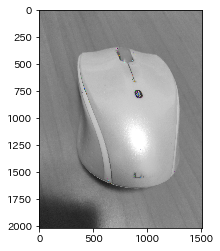

In [4]:
keypoints_img = cv2.drawKeypoints(img1, kp1, None)
plt.imshow(keypoints_img)

# 特徴のマッチング

In [5]:
# 特徴のマッチング
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# 正しいマッチングのみ保持
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append([m])

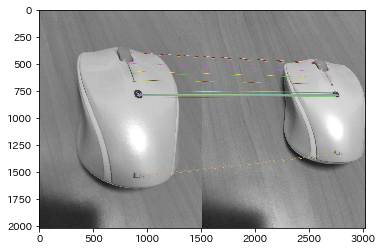

In [6]:
matches_img = cv2.drawMatchesKnn(
    img1,
    kp1,
    img2,
    kp2,
    good_matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#cv.imwrite('matches.jpg', matches_img)
plt.imshow(matches_img)

# マッチングしたキーポイントを選択

In [7]:
# 適切なキーポイントを選択
kpm1 = np.float32(
    [kp1[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
kpm2 = np.float32(
    [kp2[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# 変換行列を求める
RANSAC  
以下を繰り返して、inlierの数が最大となる変換行列Fを推定値とする
1. 対応点n点からm点をランダムに決める
1. E_reprojectionが最小になるFを推定する
1. 行列Fを用いて、n組のうち以下を満たすinlierの数を数える

$
({\bf v}'_p - {\bf F}{\bf v}'_p)^2 < T
$

In [13]:
max_iters = 2000
thresh = 3.0
n = len(good_matches)
m = int(n * 0.8)
#m = 3

In [14]:
inliers = []
matrixs = []
for i in range(max_iters):
    idx = random.sample(range(n), m)
    A = np.append(kpm1[idx].reshape(-1 ,2), np.ones([m,1]), axis=-1).T
    B = np.append(kpm2[idx].reshape(-1 ,2), np.ones([m,1]), axis=-1).T
    matrix = A @ B.T @ np.linalg.inv(B @ B.T) # F
    
    v = np.append(kpm2.reshape(-1 ,2), np.ones([n,1]), axis=-1).T
    dv = np.append(kpm1.reshape(-1 ,2), np.ones([n,1]), axis=-1).T
    fv = matrix @ v
    
    nijou = (dv-fv)[:2,:]**2
    nijouwa = nijou[0,:] + nijou[1,:]
    
    inliers.append(np.sum(nijouwa < thresh**2))
    matrixs.append(matrix)
    
F = matrixs[inliers.index(max(inliers))][:2,:]

In [15]:
affine_img2 = cv2.warpAffine(img2, F, (width, height))

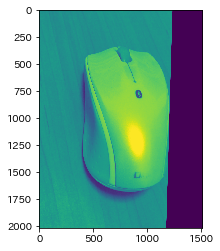

In [16]:
plt.imshow(affine_img2)

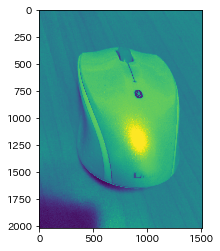

In [17]:
plt.imshow(img1)

## 関数

In [21]:
def getAffineTransformRANSAC(kp_after, kp_before, thresh=3.0, max_iters=2000):
    
    n = kp_after.shape[0]
    m = int(n * 0.8)
        
    inliers = []
    matrixs = []
    for i in range(max_iters):
        idx = random.sample(range(n), m)
        A = np.append(kp_after[idx].reshape(-1 ,2), np.ones([m,1]), axis=-1).T
        B = np.append(kp_before[idx].reshape(-1 ,2), np.ones([m,1]), axis=-1).T
        matrix = A @ B.T @ np.linalg.inv(B @ B.T) # F

        v = np.append(kp_before.reshape(-1 ,2), np.ones([n,1]), axis=-1).T
        dv = np.append(kp_after.reshape(-1 ,2), np.ones([n,1]), axis=-1).T
        fv = matrix @ v

        nijou = (dv-fv)[:2,:]**2
        nijouwa = nijou[0,:] + nijou[1,:]

        inliers.append(np.sum(nijouwa < thresh**2))
        matrixs.append(matrix)

    return matrixs[inliers.index(max(inliers))][:2,:]

In [22]:
getAffineTransformRANSAC(kpm1, kpm2)

array([[ 1.04641836e+00, -3.77026681e-02, -3.44599789e+02],
       [-9.55825531e-02,  1.39311541e+00, -1.91256978e+02]])